# there is the SHAPE dataset of 50 sequences, under 4 conditions... 

we want to see of our accessibility is good

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=3)


import matplotlib.pyplot as plt
import ShaKer.simushape as ss 
from scipy.stats import spearmanr as spear
import pandas
import numpy as np
from ShaKer.rna_tools.rnaplfold import rnaplfold
import notebook_helper as nb
asd=nb.getgenedict()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
backend module://ipykernel.pylab.backend_inline version unknown


In [24]:

from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')


# Load data

In [25]:
import ShaKer.rna_tools.rna_io as rio
import pandas

types = ["cellfree",
"incell",
"kasugamycin"]

def getdata(typ):
    return rio.get_all_data("../data/weeks194_orig/%s.react" % typ,"../data/weeks194_orig/%s.dbn" % typ)  # {key: rea, seq, stru}

data = [getdata(t) for t in types] # 2 has bad results :)


import seaborn as sns
def draw(data,ylabel="SHAPE reactivity",piclength=6, title="Experimental Reavtivity for mRNA#96",ylim=(0, 1),legend='full'):
    fig, ax = plt.subplots()
    # the size of A4 paper
    
    fig.set_size_inches(piclength,4)
    
    sns.set(style="whitegrid")
    #sns.set_context("poster")
    sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 3})
    g=sns.lineplot(data=data.T, dashes=False,legend=legend)
    g.set_xlabel('Transcript')
    g.set_ylabel(ylabel)
    plt.title(title)
    g.set(ylim=ylim)
    #fig = g.get_figure()
    #fig.savefig("output.pdf")
    return data, g
 
    
def window(stuff,wdsize=50):
    shift = wdsize/2
    windowed = [ np.median(np.array( [z for z in stuff[i:i+wdsize] if z != None] )) for i in range(0, len(stuff)-wdsize)  ]
    return np.hstack([[np.nan]*shift,windowed])  # add padding

In [29]:
for k in data[0]:
    print k, len(data[0][k][1])

glnA_162 1679
pheS_pheT_ihfA_62 3894
clpB_93 2706
raiA_95 385
mlaA_83 867
dcuA_182 1371
sdaA_67 1554
accD_82 977
tRNA_argX_tRNA_hisR_tRNA_leuT_156 447
rplY_77 386
rplK_rplA_rplJ_rplL_rpoB_rpoC_176 11258
bamD_94 847
rpsL_rpsG_fusA_tufA_133 4523
serS_41 1498
fruB_fruK_fruA_75 4052
gnd_73 1517
ytfK_189 330
rpsO_117 388
ihfB_43 408
dnaK_dnaJ_3 3464
glyQ_glyS_144 3037
rpoH_141 1109
alaS_csrA_101 3166
aspS_nudB_yebC_ruvC_71 3958
pitA_142 1638
rpsP_rimM_trmD_rplS_96 2099
sodA_165 741
ftsQ_ftsA_ftsZ_10 4184
pgi_179 1847
_157 195
pepA_holC_valS_191 5167
lrp_40 811
purA_187 1403
ppa_190 620
fabI_55 898
oppA_oppB_oppC_oppD_oppF_53 6108
accA_24 1327
hspQ_46 499
ptsH_ptsI_crr_86 2777
rpmB_rpmG_147 766
ppc_173 2754
fabR_yijD_175 1306
rpsF_priB_rpsR_rplI_188 1559
yifK_155 1449
hemL_19 1417
seqA_pgm_33 2366
rpmH_rnpA_yidD_yidC_149 2645
ncRNA_ssrS_107 183
rne_48 3582
rhlB_gpp_153 2903
ygiB_ygiC_112 1875
cydA_cydB_ybgT_ybgE_34 3457
pnp_nlpI_yrbN_deaD_116 5413
tRNA_glyW_tRNA_cysT_tRNA_leuZ_72 412
trxA_rh

# FIG 2 B

In [27]:
# we will wrap the result in plfold .. 
def plf(seq,reactivity=None):
    return rnaplfold(seq,reactivity)


TE = pandas.read_csv("../data/weeks194_orig/translationefficiency.csv")
TE = dict(zip(TE["Gene"],TE["Translation efficiency (AU)"]))

def makedf(predictions,seq,script):
    names, genes = nb.get_genetrack_multigene(script,data[0],asd, drawindex=(0,len(seq)))
    names = [name[6:]+" TE:"+str(TE.get(name[6:],"not in the list")) for name in names]
    return pandas.DataFrame( [ window(plf(seq,p)) for p in predictions]+[window(plf(seq))]+genes,
                            index=types+["Thermodynamics"]+names)
        
def makedf_nofold(predictions,seq,script):
    names, genes = nb.get_genetrack_multigene(script,data[0],asd, drawindex=(0,len(seq)))
    names = [name[6:]+" TE:"+str(TE.get(name[6:],"not in the list")) for name in names]
    return pandas.DataFrame( [ window(p) for p in predictions]+[window(plf(seq))]+genes,
                            index=types+["Thermodynamics"]+names)
def makeplot_nofold(shapedata,seq,script, title = "title"):
    d,g = draw(makedf_nofold(shapedata,seq,script),title=title,ylabel="Accessibility",piclength=24,legend=False)
    plt.legend(labels=d.index,
               loc=2,
               ncol=6, 
               borderaxespad=.5)

def makeplot(shapedata,seq,script, title = "title"):
    d,g = draw(makedf(shapedata,seq,script),title=title,ylabel="Accessibility",piclength=24,legend=False)
    plt.legend(labels=d.index,
               loc=2,
               ncol=6, 
               borderaxespad=.5)

def makeplot(shapedata,seq,script, title = "title"): # papaer beautyful, script is the transcript name
    d,g = draw(makedf(shapedata,seq,script),title=title,ylabel="Accessibility",piclength=24,legend=False)
    
    plt.legend(labels=["Cellfree","Incell","Kasugamycin"]+list(d.index[3:]),
               loc=2, # 0 -> top midle , 1 -> top right
               ncol=3, 
               borderaxespad=-8)


In [ ]:
%%time
# define problem
keys = data[0].keys()
keys_predict = ["rpsP_rimM_trmD_rplS_96","dusB_fis_130"]
keys_train = [k for k in  keys if k not in keys_predict][:25]
# make models
model_xgb=[ss.make_xgbreg() for i in range(len(data))]

models = [ss.make_model(dat,keys_train,model=mod) for dat,mod in zip(data,model_xgb) ]

allpredictions = {k:[ss.predict(mod, data[0][k][1]) for mod in models] for k in keys_predict}




In [ ]:



def calc_and_draw(k):
    sequence = data[0][k][1]
    predictions = allpredictions[k]
    papr_data = [data[a][k][0] for a in range(3)]
    idd= k.split("_")[-1]
    #makeplot(papr_data,sequence,k, "mRNA#%s ShaKer generated Accessibilities" % idd)
    makeplot(predictions,sequence,k,"mRNA#%s Shaker Prediction" % idd)
    
for k in keys_predict:
    #%lprun -f calc_and_draw calc_and_draw(k)
    calc_and_draw(k)
    

In [ ]:
# ok 
#gene/ avg_value_real, avg value pred, VA methods
# WHAT? 

def plf(seq,reactivity=None):
    return np.array(rnaplfold(seq,reactivity))




# for all the sequences:
for k in keys_predict:
    
    # get gene names 
    t_id = int(k.split("_")[-1])
    genes = asd[t_id]

    sequence = data[0][k][1]

    # for all models
    predictions = [plf(sequence,ss.predict(mod, sequence)) for mod in models]
    #papr_data = [plf(sequence, [a if a!=None else np.nan for a in data[a][k][0]]) for a in range(3)]
    papr_data = [plf(sequence,data[a][k][0]) for a in range(3)]
    
    
    
    seqq = plf(sequence)
    #for pred, pap in zip(predictions,papr_data):


    # for all genes: 
    res=[]
    for s,e in genes:
        
        res.append([np.nanmean(d[s:e]) for d in papr_data]+[np.nanmean(d[s:e]) for d in predictions]+[np.mean(seqq[s:e])])


    print pandas.DataFrame(res)

        
# accessibilities , X is data,prediction,thermodyn, Y  is genes

# FIG 6 -- C, D, E    DIFF PLOT TO MAKE A POINT

#   

In [ ]:
# NEW VERSION WITH COKE AND HOOKERZ

# define problem
keys = data[0].keys()
keys_predict = ["rplM_rpsI_127","rpsP_rimM_trmD_rplS_96"]   # WHAT ARE THESE???
keys_train = [k for k in  keys if k not in keys_predict][:10]

# make models
model_xgb=[ss.make_xgbreg() for i in range(len(data))]
models = [ss.make_model(dat,keys_train,model=mod) for dat,mod in zip(data,model_xgb) ]





In [ ]:
# we will wrap the result in plfold .. 
def plff(seq,reactivity=None):
    return rnaplfold(seq,reactivity)
    
def makedff(prediction,real,seq,script):
    # TODO: 
    #      -pred,real,real-pred, plff 
    names, genes = nb.get_genetrack_multigene(script,data[0],asd, drawindex=(0,len(seq)))
    pre,rea = [ window(plff(seq,p)) for p in [prediction, real]  ]
    
    #diff = np.absolute(np.array(plff(seq,real))-np.array(plff(seq,prediction))) # div in values
    #diff = window(diff,wdsize=10)             
    diff = np.absolute(np.array(rea)-np.array(pre))
    return pandas.DataFrame([pre,rea,diff] +[window(plff(seq))]+genes,
                            index=['prediction','real','difference',"Thermodynamics"]+names)

def makeplott(pred,real,seq,script, title = "title"):
    d,g = draw(makedff(pred,real,seq,script),title=title,ylabel="Accessibility",piclength=12,legend=False)
    plt.legend(labels=d.index,
               loc=2,
               ncol=6, 
               borderaxespad=.5)


for k in keys_predict:
    sequence = data[0][k][1][:400]
    predictions = [ss.predict(mod, sequence) for mod in models]
    papr_data = [data[a][k][0][:len(sequence)] for a in range(3)]
    idd= k.split("_")[-1]
    for typ,pred,real in zip(types,predictions, papr_data):
        makeplott(pred,real,sequence,k, "mRNA#%s %s" % (idd,typ))
        
    # train cfree... compare to incell
    makeplott(predictions[0],papr_data[1],sequence,k, "mRNA#%s  cellfree(train)_vs_incell" % (idd))
    makeplott(predictions[0],papr_data[2],sequence,k, "mRNA#%s  cellfree(train)_vs_gusaga" % (idd))
    
    
    

In [ ]:

# degine problem
keys = data[0].keys()
keys_predict = ["rplM_rpsI_127","rpmH_rnpA_yidD_yidC_149",'rpmB_rpmG_147']
keys_train = [k for k in  keys if k not in keys_predict][:5]
# make models
model_xgb=[ss.make_xgbreg() for i in range(len(data))]
models = [ss.make_model(dat,keys_train,model=mod) for dat,mod in zip(data,model_xgb) ]



In [ ]:
np.array(data[1]["rplM_rpsI_127"][0][:10])==None


In [ ]:
# FIG 6 STRUCT, BUT ONLY FOLD SUBSEQUENCE ... TO AVOID INSTALLING SUPERFOLD
from ShaKer.rna_tools.rnafold import fold
from ShaKer.rna_tools.rna_accuracy import get_structure_accuracy

def stripstruct(struct, start,end):
    stack=[]
    refstr= ['.']*len(struct)
    for now,cha in enumerate(struct):
            if cha == '(':
                stack.append(now)
            if cha == ')':
                st = stack.pop()
                if now < end and st > start:
                    refstr[now]=')'
                    refstr[st]='('

    return ''.join(refstr)


# for all the sequences in fig 6 c-e 
for k,(start,end) in zip(keys_predict,[(6,209),(25,242),(196,349)]):

    sequence = data[0][k][1]
    
    # get "real" struct
    incellreact = data[1][k][0]
    struct = fold(sequence[start:end], incellreact[start:end])
    print struct
    
    # get "pred" structures
    predict_reas = [ss.predict(mod, sequence) for mod in models]

    for typ,predict_rea in zip(types,predict_reas):
        print "accu %s" % typ ,get_structure_accuracy(sequence[start:end],struct,react=predict_rea[start:end])
        print fold(sequence[start:end],predict_rea[start:end])
        print sequence[start:end]

    print "accu thermodynamics" ,get_structure_accuracy(sequence[start:end],struct,react=None)
    print fold(sequence[start:end])
    print "****"
    print "****"
    

In [ ]:
# Fig 6 trying on the struct stuff... 

# we want -150 +50 , then we fold real and use that for accu cmp, then we use thermo and do accu cmp again
from ShaKer.rna_tools.rnafold import fold
from ShaKer.rna_tools.rna_accuracy import get_structure_accuracy

def stripstruct(struct, start,end):
    stack=[]
    refstr= ['.']*len(struct)
    for now,cha in enumerate(struct):
            if cha == '(':
                stack.append(now)
            if cha == ')':
                st = stack.pop()
                if now < end and st > start:
                    refstr[now]=')'
                    refstr[st]='('

    return ''.join(refstr)


# for all the sequences in fig 6 c-e 
for k,(start,end) in zip(keys_predict,[(6,209),(25,242),(196,349)]):

    sequence = data[0][k][1]
    
    # get "real" struct
    incellreact = data[1][k][0]
    struct = fold(sequence, incellreact)

    refstr = stripstruct(struct, start,end)
    print refstr[start:end]
    # get "pred" structures
    predict_reas = [ss.predict(mod, sequence) for mod in models]

    for typ,predict_rea in zip(types,predict_reas):
        print "accu %s" % typ ,get_structure_accuracy(sequence,refstr,react=predict_rea)
        print stripstruct(fold(sequence,predict_rea),start,end)[start:end]
        print sequence[start:end]

    print "accu thermodynamics" ,get_structure_accuracy(sequence,refstr,react=None)
    print stripstruct(fold(sequence),start,end)[start:end]
    print "****"
    

In [ ]:
# Fig 6 trying on the struct stuff... 

# we want -150 +50 , then we fold real and use that for accu cmp, then we use thermo and do accu cmp again
from ShaKer.rna_tools.rnafold import fold
from ShaKer.rna_tools.rna_accuracy import get_structure_accuracy



# for all the sequences in fig 6 c-e 
for k in keys_predict:

    # window of interest: 
    tid = int(k.split("_")[-1])
    start_gene1 = asd[tid][0][0]
    start= max(start_gene1-150,0)
    end = start_gene1+50
    sequence = data[0][k][1]

    
    # get "real" struct
    incellreact = data[1][k][0]
    struct = fold(sequence, incellreact)

    # get "pred" structures
    predict_reas = [ss.predict(mod, sequence) for mod in models]

    for typ,predict_rea in zip(types,predict_reas):
        stack=[]
        refstr= ['.']*len(struct)
        for now,cha in enumerate(struct):
                if cha == '(':
                    stack.append(now)
                if cha == ')':
                    st = stack.pop()
                    if now < end and st > start:
                        refstr[now]=')'
                        refstr[st]='('

        refstr=''.join(refstr)

        print "accu %s" % typ ,get_structure_accuracy(sequence,refstr,react=predict_rea)

    print "accu thermodynamics" ,get_structure_accuracy(sequence,refstr,react=None)
    print "****"
    


In [ ]:


# degine problem
keys = data[0].keys()
keys_predict = ["rplM_rpsI_127","rpmH_rnpA_yidD_yidC_149",'rpmB_rpmG_147']
keys_train = [k for k in  keys if k not in keys_predict][:5]
# make models
model_xgb=[ss.make_xgbreg() for i in range(len(data))]
models = [ss.make_model(dat,keys_train,model=mod) for dat,mod in zip(data,model_xgb) ]


for k in keys_predict:
    sequence = data[0][k][1][:400]
    predictions = [ss.predict(mod, sequence) for mod in models]
    papr_data = [data[a][k][0][:len(sequence)] for a in range(3)]
    idd= k.split("_")[-1]
    makeplot(papr_data,sequence,k, "mRNA#%s Experimental Data" % idd)
    makeplot(predictions,sequence,k,"mRNA#%s Shaker Prediction" % idd)


# FIG 6 -- C, D, E   === regular

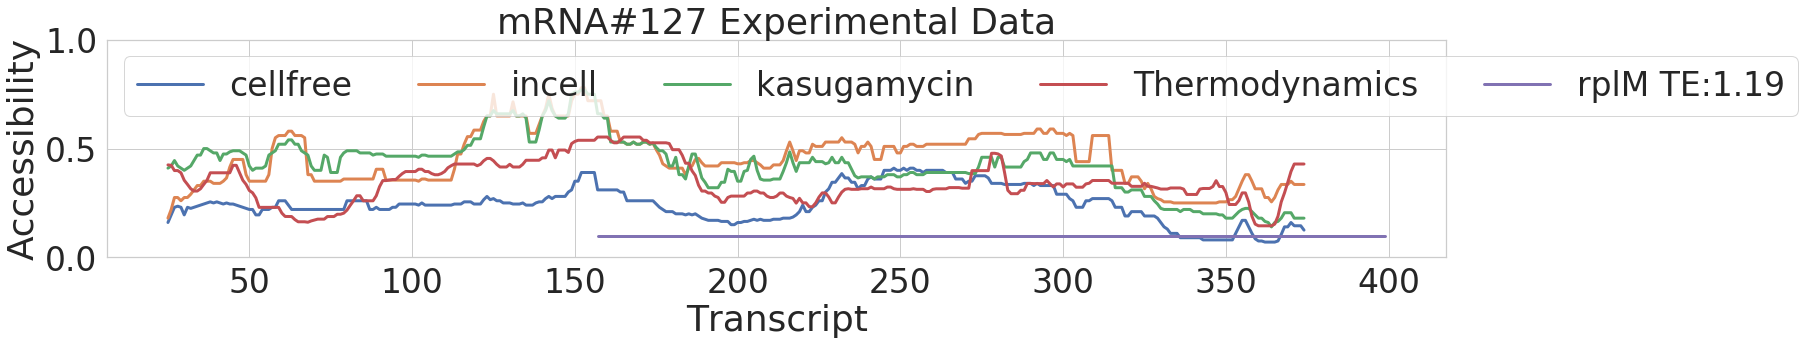

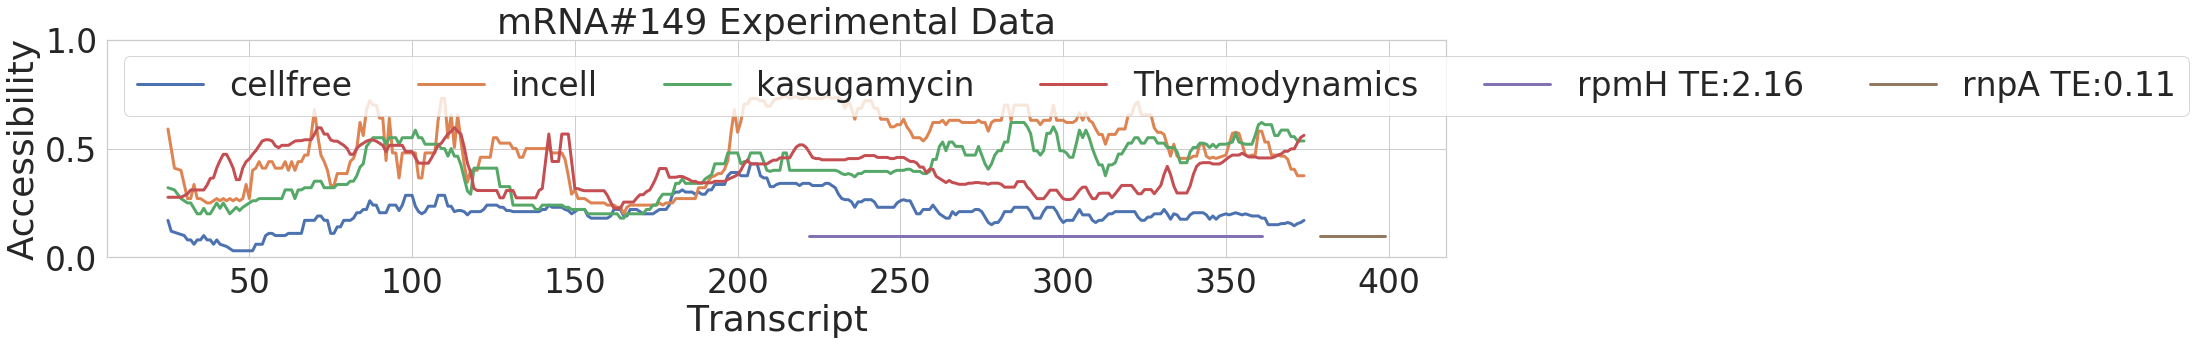

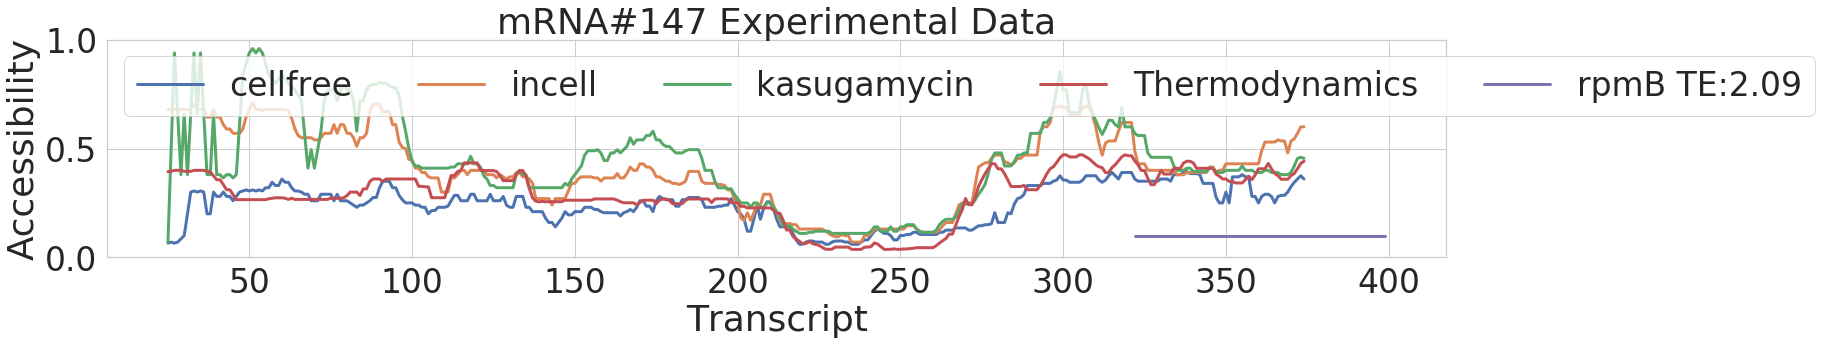

In [28]:

for k in keys_predict:
    sequence = data[0][k][1][:400]
    #predictions = [ss.predict(mod, sequence) for mod in models]
    papr_data = [data[a][k][0][:len(sequence)] for a in range(3)]
    idd= k.split("_")[-1]
    makeplot_nofold(papr_data,sequence,k, "mRNA#%s Experimental Data" % idd)
    #makeplot(predictions,sequence,k,"mRNA#%s Shaker Prediction" % idd)
    #makeplot(papr_data,sequence,k, "mRNA#%s Experimental Data" % idd)

CPU times: user 1min 41s, sys: 11.7 s, total: 1min 52s
Wall time: 3min 13s
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=36.0 to DejaVu Sans (u'/home/ikea/.local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 2.050000
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=33.0 to DejaVu Sans (u'/home/ikea/.local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 2.050000


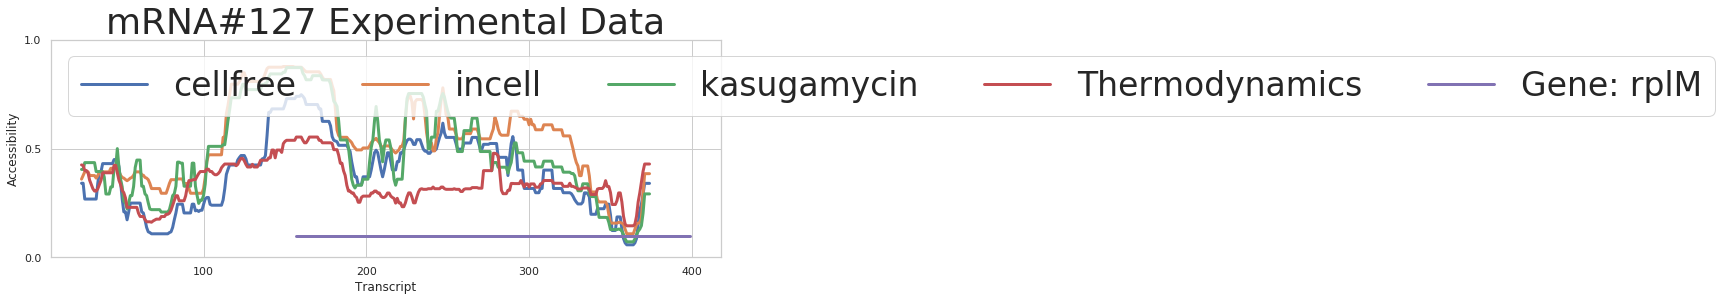

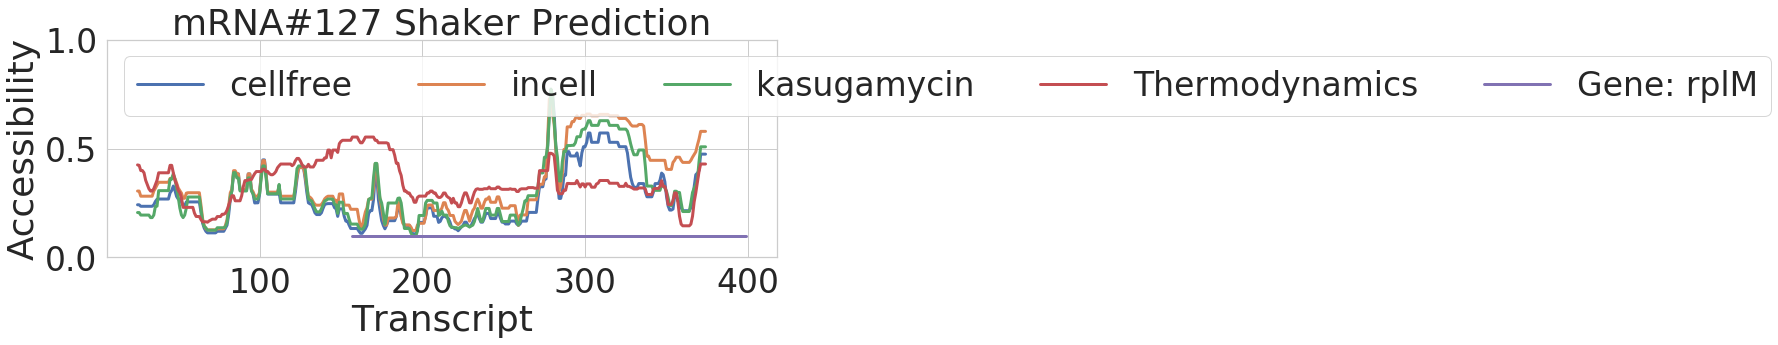

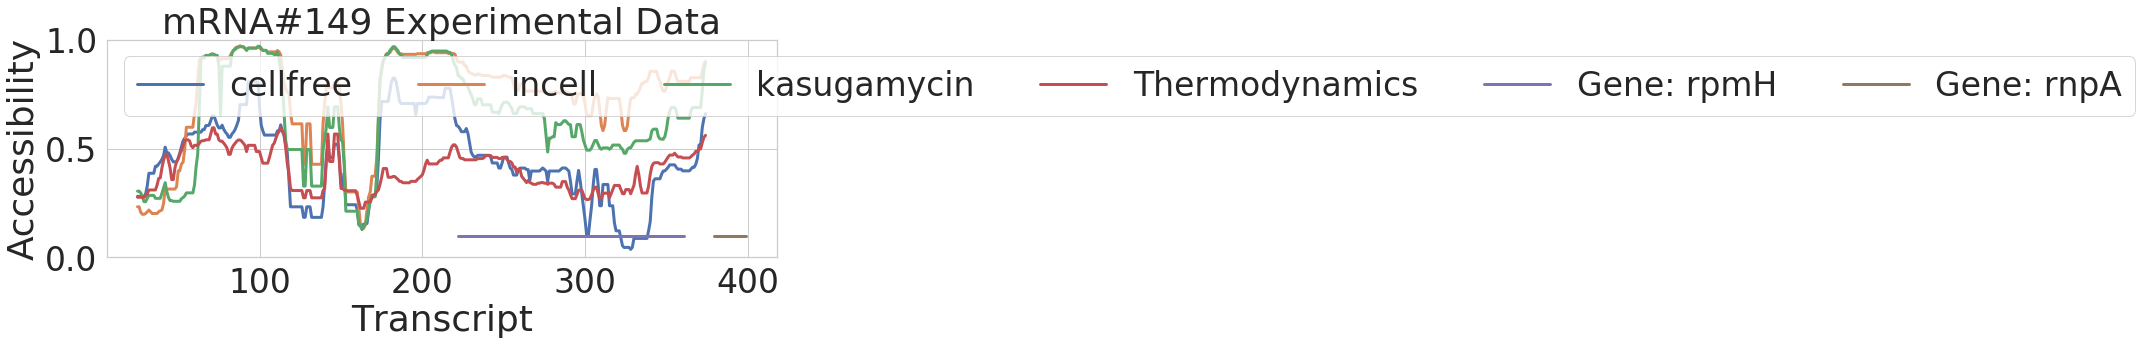

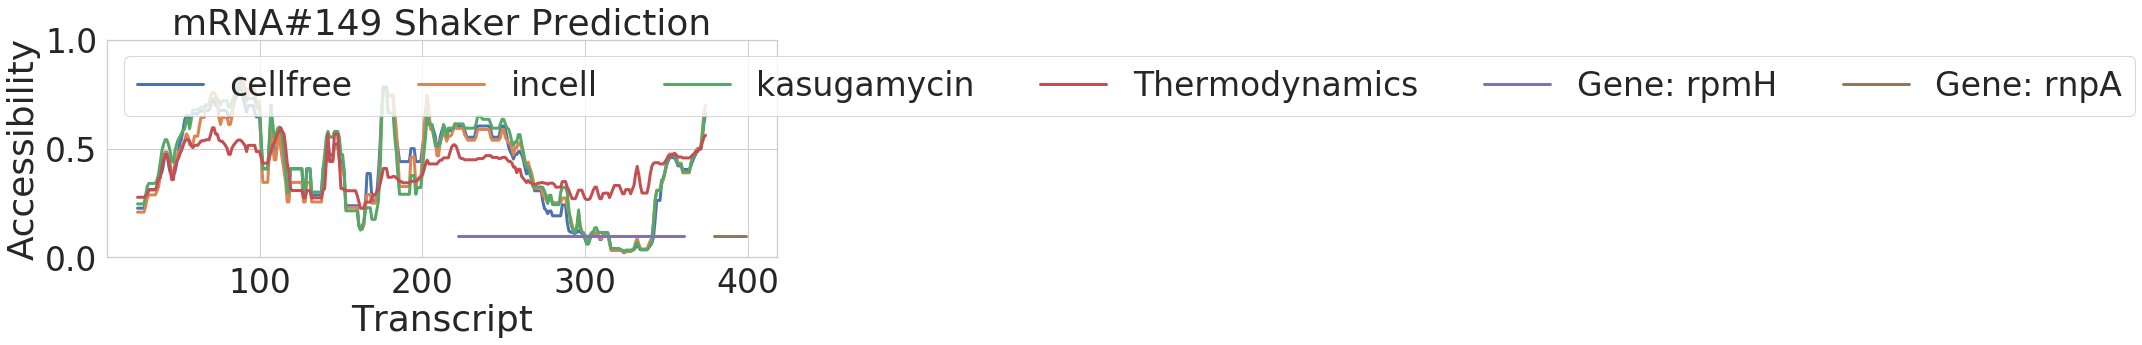

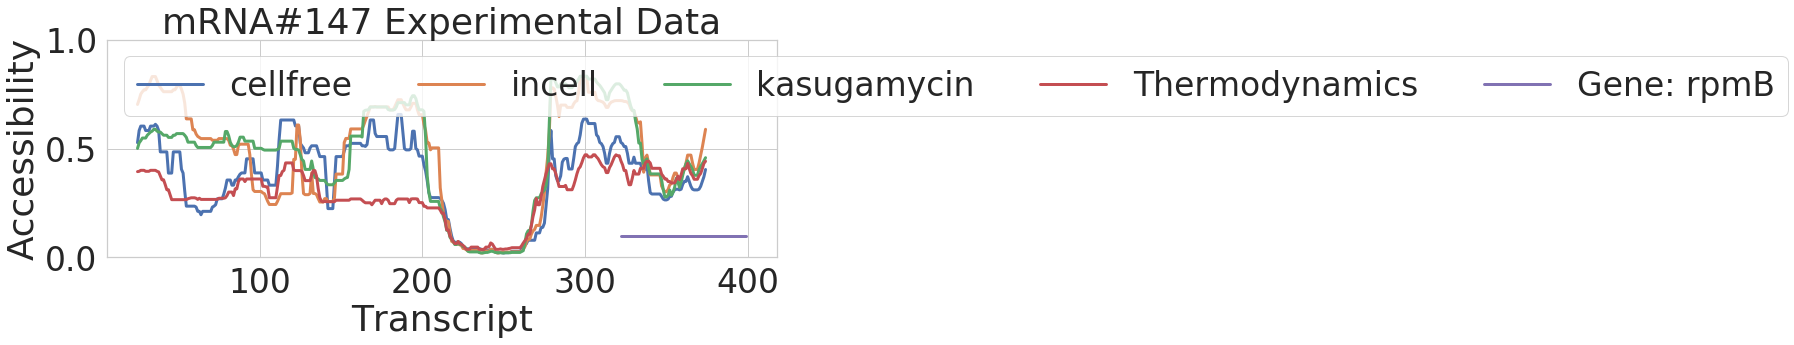

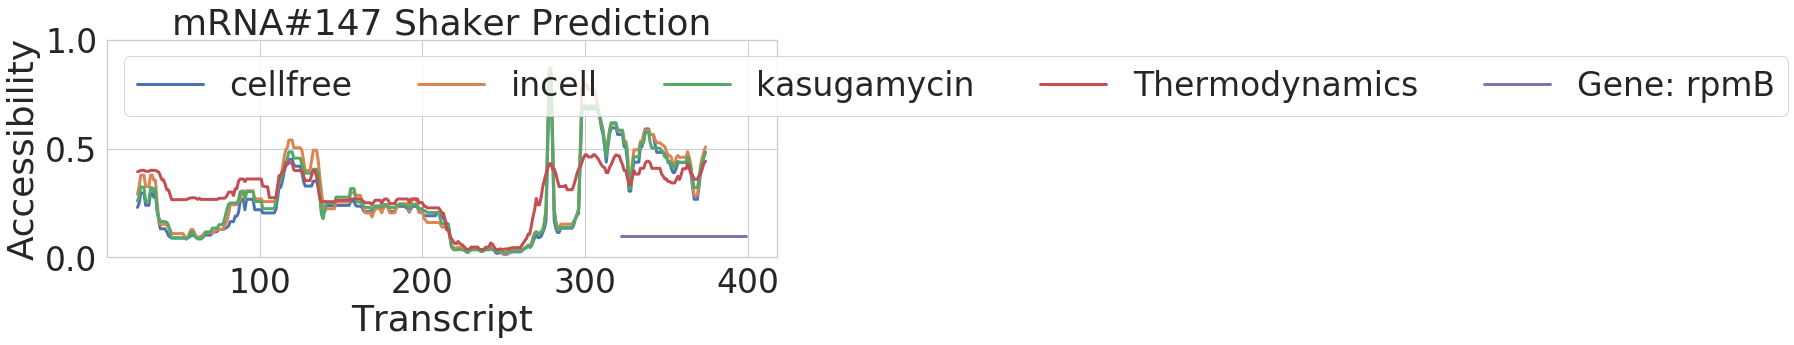

In [26]:
%%time

# degine problem
keys = data[0].keys()
keys_predict = ["rplM_rpsI_127","rpmH_rnpA_yidD_yidC_149",'rpmB_rpmG_147']
keys_train = [k for k in  keys if k not in keys_predict][:5]
# make models
model_xgb=[ss.make_xgbreg() for i in range(len(data))]
models = [ss.make_model(dat,keys_train,model=mod) for dat,mod in zip(data,model_xgb) ]


for k in keys_predict:
    sequence = data[0][k][1][:400]
    #predictions = [ss.predict(mod, sequence) for mod in models]
    papr_data = [data[a][k][0][:len(sequence)] for a in range(3)]
    idd= k.split("_")[-1]
    makeplot_nofold(papr_data,sequence,k, "mRNA#%s Experimental Data" % idd)
    #makeplot(predictions,sequence,k,"mRNA#%s Shaker Prediction" % idd)
    #makeplot(papr_data,sequence,k, "mRNA#%s Experimental Data" % idd)



---

# Fig 3d

In [ ]:

keys = data[0].keys()
keys_train = keys[:5]
keys_predict = keys[-5:]

models = [ss.make_xgbreg()  for dat in data]
models = [ ss.make_model(dat,keys_train, model=mod)for dat,mod in zip(data,models) ]


predictions = [[plf(data[0][k][1][:150],ss.predict(mod, data[0][k][1][:150])) for k in keys_predict] for mod in models]



In [ ]:
res = [np.array(p).mean(axis=0) for p in predictions]
mystuff = pandas.DataFrame([ window(p) for p in res],index=types)

draw(mystuff)


# DO THE SAME FOR GENESTARTSITE +-100

In [ ]:
%%time

import sys
sys.path.insert(0,'../')

import data.weeks194_orig.remove_genes as d




# get data
keys = data[0].keys()
print len(keys)
keys_train = keys[:100]
keys_predict = keys[-25:]




# make model
models = [ss.make_xgbreg() for e in range(len(data))]
models = [ ss.make_model(dat,keys_train, model=mod)for dat,mod in 
          zip(data,models) ]




In [ ]:
%%time
# PREDICTION
from rna_tools.rnaplfold import rnaplfold



# select gene start 
genstartdict = d.read_genes()


def cut_genestart(k,sequence):
    """there is a sequence(of anything), we center the startsite of the first gene and add padding
    when necessary.
    returns cut_sequence, padleft, padright"""
    """helper for the 2 functions below"""
    index = int(k.split("_")[-1])
    genestart = genstartdict[index][0][0] # [transcript_index gene_index start]
    geneend = genstartdict[index][0][1] # [transcript_index gene_index end]
    sequence = sequence[:geneend]  # sequence[:geneend]
    endpointindex = min(genestart+150, geneend) 
    pre = sequence[max(genestart-150,0):genestart] # everything before the genestart
    post =   sequence[genestart:min(endpointindex, len(sequence))] # after genestart
    
    if type(sequence) != str:
        pre = [e if e != None else np.nan for e in pre ]
        post = [e if e != None else np.nan for e in post ]
    
    answer= pre+post , abs(min(genestart-150,0)), max(genestart+150-len(sequence),0) 
    # check error
    if (len(answer[0])+answer[1]+answer[2])!= 300:
        print answer, k,sequence, geneend
    # track progress alittle biiit
    print ".",
    return answer


    
# predict
def predwrap(k,mod):
    """predicts for a transcript"""
    seq, padstart, padend = cut_genestart(k,data[0][k][1])
    
    res = ss.predict(mod, seq )
    a=np.full((padstart,), np.nan, dtype=float)
    b = np.full((padend,), np.nan, dtype=float)
    ret= np.hstack( [a,res, b] )
    return ret

def plfoldrap(k):
    """predicts for a transcript"""
    seq, padstart, padend = cut_genestart(k,data[0][k][1])
    res = rnaplfold ( seq )
    a=np.full((padstart,), np.nan, dtype=float)
    b = np.full((padend,), np.nan, dtype=float)
    ret= np.hstack( [a,res, b] )
    return ret


predictions = [[predwrap(k,mod) for k in keys_predict] for mod in models]
predictions.append([plfoldrap(k) for k in keys_predict])
# we want the mean at nucleodide possition [-150.. 150] over all sequences...
res = [np.nanmean(np.array(p),axis=0) for p in predictions]

# windowing to smoothe the plot
mystuff = pandas.DataFrame([ window(p) for p in res],index=types+["plfold"])

draw(mystuff)

In [ ]:
#Original DAta

# select gene start 
genstartdict = d.read_genes()


def plfoldrap(k):
    seq, padstart, padend = cut_genestart(k,data[0][k][1]) # this is the verison above
    res = rnaplfold ( seq )
    a=np.full((padstart,), np.nan, dtype=float)
    b = np.full((padend,), np.nan, dtype=float)
    ret= np.hstack( [a,res, b] )
    return ret

# predict
def predwrap(k, exp):
    seq, padstart, padend = cut_genestart(k,data[exp][k][0])
    res =  np.array(seq) 
    a=np.full((padstart,), np.nan, dtype=float)
    b = np.full((padend,), np.nan, dtype=float)
    ret= np.hstack( [a,res, b] )
    return ret

predictions = [[predwrap(k,mod) for k in keys_predict] for mod in range(3)]
predictions.append([plfoldrap(k) for k in keys_predict])
# we want the mean at nucleodide possition [-150.. 150] over all sequences...
#res = [np.array(p).mean(axis=0) for p in predictions]

res = [np.nanmean(np.array(p),axis=0) for p in predictions]


# windowing to smoothe the plot
mystuff = pandas.DataFrame([ window(p) for p in res],index=types+["plfold"])
draw(mystuff)